<a href="https://colab.research.google.com/github/Shanil97/Balance-Alert/blob/main/Fbprophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
!pip install pystan==2.19.1.1
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import matplotlib as mpl

In [58]:
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [59]:
df = pd.read_csv("Sirasa_2021.csv")
df.shape

(592, 3)

In [60]:
df.dtypes

CHANNEL     int64
TIME_KEY    int64
COUNT       int64
dtype: object

In [61]:
df['TIME_KEY'] = pd.to_datetime(df['TIME_KEY'], format='%Y%m%d')

In [77]:
#
p_df = df.iloc[:-1,:]
p_df  = p_df.sort_values('TIME_KEY')

In [78]:
#express to plot entire data
fig = px.line(p_df.reset_index(), x='TIME_KEY', y='COUNT', title='Sirasa viewer counts')
#slider
'''fig.update_xaxes(
    ''rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='2y', step="year", stepmode="backward"),
              dict(count=2, label='5y', step="year", stepmode="backward")
        ])
    )
)'''
fig.show()

Modling

In [83]:
from fbprophet import Prophet
viewer_df = p_df.reset_index()[['TIME_KEY', 'COUNT']].rename({'TIME_KEY':'ds', 'COUNT':'y'}, axis='columns')

In [84]:
viewer_df.head()

,ds,y
0,2021-01-01,6024
1,2021-01-02,6077
2,2021-01-03,6080
3,2021-01-04,5137
4,2021-01-05,4855


In [87]:
#train test split
train = viewer_df[(viewer_df['ds'] >= '2021-01-01') & (viewer_df['ds'] <= '2022-03-31')]
test = viewer_df[(viewer_df['ds'] > '2022-03-31')]

Create Prophet model

In [88]:
m = Prophet(changepoint_range=0.95)
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting

create a dataframe with daily frequency

In [89]:
future = m.make_future_dataframe(periods=100, freq='D')

In [90]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
550,2022-07-05,1173.525802,550.548384,1786.087377
551,2022-07-06,1177.502449,510.113234,1835.277301
552,2022-07-07,1136.890913,501.592997,1775.068887
553,2022-07-08,1220.020091,565.877913,1873.790644
554,2022-07-09,1864.361807,1246.660163,2534.903496


difference between actual and predicted values

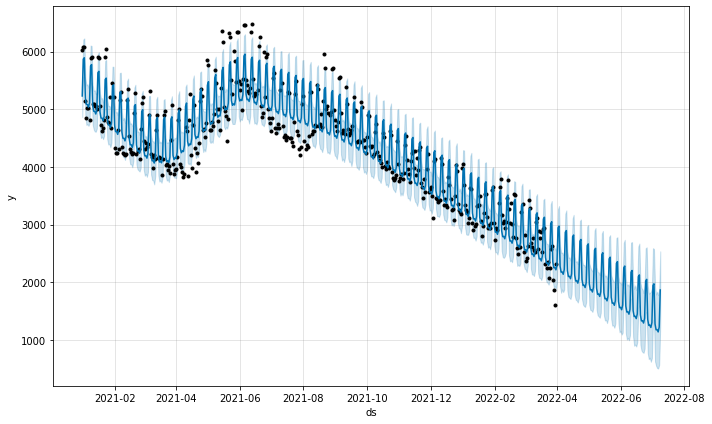

In [91]:
result = pd.concat([viewer_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
fig1 = m.plot(forecast)

Decomposition

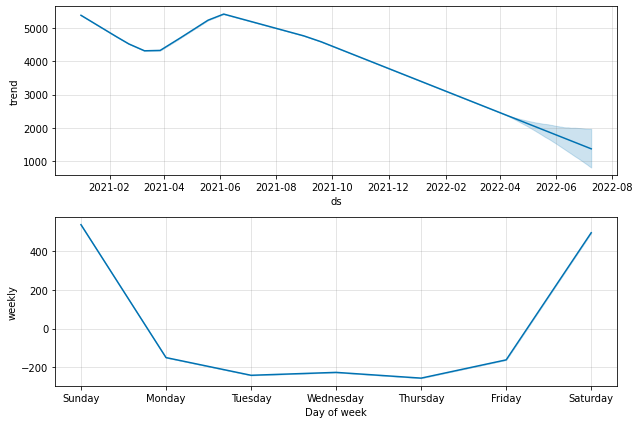

In [92]:
comp = m.plot_components(forecast)

Anomaly and outlier detection

In [93]:
result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']

In [94]:
result[result['error'].abs() > 1.5 * result['uncertainty']]

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2022-04-03,4167,2971.901714,2665.794041,3321.357346,1195.098286,655.563304
2022-04-04,3339,2275.848059,1930.429307,2630.434547,1063.151941,700.005240
2022-04-14,3573,2060.077764,1707.951405,2375.819528,1512.922236,667.868123
2022-05-06,3007,1912.410229,1567.615791,2266.739543,1094.589771,699.123752
2022-05-09,3823,1891.186871,1523.308756,2260.888370,1931.813129,737.579615
2022-05-10,4032,1788.983703,1425.945007,2174.255915,2243.016297,748.310908
2022-05-11,3473,1792.960350,1406.608712,2169.988492,1680.039650,763.379779
2022-05-12,3301,1752.348813,1382.692020,2123.152296,1548.651187,740.460276
2022-05-16,3011,1814.254634,1425.920926,2167.299248,1196.745366,741.378323


,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2021-01-01,6024,NaN,NaN,NaN,NaN,NaN
2021-01-02,6077,NaN,NaN,NaN,NaN,NaN
2021-01-03,6080,NaN,NaN,NaN,NaN,NaN
2021-01-04,5137,NaN,NaN,NaN,NaN,NaN
2021-01-05,4855,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-08-11,1903,2093.041271,1528.891660,2668.469402,-190.041271,1139.577743
2022-08-12,1620,2105.422080,1578.813016,2651.255250,-485.422080,1072.442233
2022-08-13,1798,2365.349648,1831.155805,2908.442089,-567.349648,1077.286284


In [95]:
result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)
#result['anomaly'] = np.where(np.abs(x['error']) > 1.5*x['uncertainty']), 'Yes', 'No') #Alternate way

In [96]:
result

,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly
ds,,,,,,,
2021-01-01,6024,5229.309927,4864.399902,5581.763919,794.690073,717.364017,No
2021-01-02,6077,5867.821211,5554.676509,6208.099723,209.178789,653.423213,No
2021-01-03,6080,5892.479359,5558.378570,6228.680542,187.520641,670.301973,No
2021-01-04,5137,5190.595271,4887.853976,5551.930972,-53.595271,664.076995,No
2021-01-05,4855,5082.561670,4726.160313,5411.184947,-227.561670,685.024634,No
...,...,...,...,...,...,...,...
2022-08-10,1770,NaN,NaN,NaN,NaN,NaN,No
2022-08-11,1903,NaN,NaN,NaN,NaN,NaN,No
2022-08-12,1620,NaN,NaN,NaN,NaN,NaN,No


In [97]:
#visualize the anomaly data
fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title='NYC Taxi Demand')

fig.show()